In [1]:
import os, re
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from tqdm import tqdm, tqdm_notebook

import config as cfg
import src.plot_utils as pu
import src.model_utils as mu

In [2]:
sns.set()
plt.style.use('ggplot')

In [3]:
pdbs = ['5c3i', '4nif', '4fa8', '1uug', '4goj', '2a1t', '4pj2', '2c2v', '1e6j', '3f7p', '1fcc',
        '1nbf', '3cu1', '1l9j', '1nql', '3cii', '2hj9', '3l89', '1is7', '3p11', '1gg2', '4pw9',
        '4di3', '2bcn', '4m5z', '2o25', '4dss', '3pnl', '3g6d', '4fqr', '4bmp', '1s78', '4xig',
        '4gxu', '3lvj', '1z5y', '5e0k', '3t1q', '3pro', '5cra', '4v2c', '3oun', '2gwf', '2pu9',
        '1w1i', '4wjg', '1lb2', '2g45', '3a8i', '1v5i', '4p2a', '4xs0', '3tg1', '3l5n', '3rvd',
        '4xr8', '3l1z', '2nqd', '1f6m', '1s1q', '2qyi', '2xwb', '3hi6', '5cec', '1wej']

In [4]:
# Load a randomized score
#random_score = pd.DataFrame(np.random.rand(len(pdbs)*100), columns=['score'])
#random_score['pdb_code'] = pdbs * 100
#random_score = random_score.sort_values('pdb_code')
#random_score['native'] = ([True] + [False] * 99) * len(pdbs)
#random_score.to_pickle('../data/results/Random_score')
random_score = pd.read_pickle('data/scores/Random_score')
# random_score = random_score.pdb_code.drop(['2a1t', '1is7', '4fqr', '4gxu', '1w1i', '3l5n'], axis=0)

In [5]:
# Load DFIRE scores
dfire_scores = pd.read_pickle('data/scores/dDFIRE_score')

In [6]:
# Load fastcontact scores
fastcontact_scores = pd.read_pickle('data/scores/FastContact_score')
fastcontact_scores['score'] = fastcontact_scores['des']

In [7]:
# Load SPIDER scores
spider_scores = pd.read_pickle('data/scores/SPIDER_score')

In [8]:
# Load logistic regression score
logit_score = pd.read_pickle('data/ml_models/LogRes-score')

In [20]:
from collections import Counter
def plot_ranking_performance(models, sort_ascending=True, figsize=(15, 8),score_col='score'):
    """ Plots the cumulative success rate of native-like hits against
    the number of predictions for multiple provided models.

    Parameters
    ----------  
        models: Dict{str(model_name), array-like(score), dataframe containing labels and pdb_codes}
            dictionary of model name followed by the given score to this
            y dataframe
        sort_ascending : boolean
            True if lower score is equal to a better model, False otherwise
    """
    mustard = {}
    # prepare the plot
    plt.ylabel('Success Rate (%)')
    plt.xlabel('Number of Predictions')
    plt.xscale('log')
    plt.xlim([1, 100])
    plt.yticks(np.arange(0, 101, 10))
    plt.xticks([1, 10, 100], labels=[1, 10, 100])

    # for each model, calculate the values and plot them
    for model_name, y in models.items():

        # get the scores from each model and sort the complexes by score
        results = y[['pdb_code', 'native', score_col]].copy()
        results.sort_values(score_col, inplace=True, ascending=sort_ascending)

        # get the predicted ranks for each pdb in the set
        hits = []
        for pdb in y.pdb_code.unique():
            temp = results.loc[results.pdb_code == pdb].copy()
            temp['rank'] = list(range(1, 101))
            hits.append(int(temp.loc[temp.native == True, 'rank']))
    
        # calculate the success rate at top n predictions
        hit_count = pd.DataFrame(sorted(Counter(hits).items()), columns=['rank', 'counter'])
        hit_stats = pd.DataFrame(data=np.arange(1, 101), columns=['rank']) 
        hit_stats = hit_stats.merge(hit_count, how='outer', on='rank')
        hit_stats.fillna(0, inplace=True)

        hit_stats['cum_sum'] = np.cumsum(hit_stats['counter'])
        hit_stats['cum_perc'] = (hit_stats['cum_sum'] / np.sum(hit_stats['counter'])) * 100

        # plot the valueslabel=f'{model_name} :AUC = {auc(fpr, tpr):.4f}
        if model_name != 'Random':
            plt.plot(hit_stats['rank'], hit_stats['cum_perc'], label=f'{model_name}', linewidth=3.0)
        else:
            plt.plot(hit_stats['rank'], hit_stats['cum_perc'], label=f'{model_name}', linewidth=3.0)

        mustard[model_name] = hit_stats

    # add legend + display plot
    plt.legend()
    # plt.show()
    return mustard


In [33]:
ax['LogRes*'].counter.std()

2.249017742944866

In [34]:
ax['dDFIRE'].counter.std()

1.7078251276599357

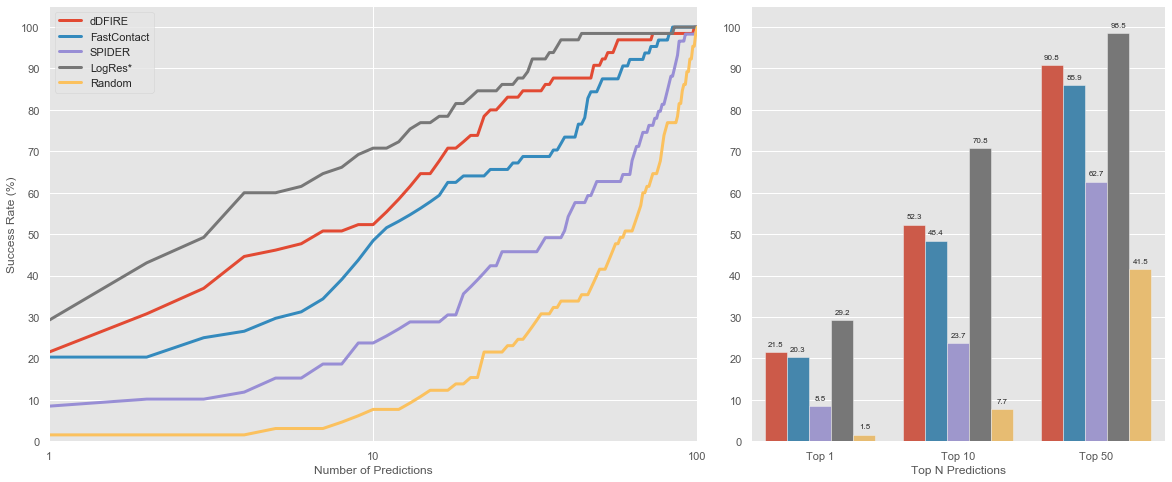

In [21]:
models = {
    'dDFIRE': dfire_scores.loc[random_score.pdb_code.isin(pdbs)],
    'FastContact': fastcontact_scores.loc[random_score.pdb_code.isin(pdbs)],
    'SPIDER': spider_scores.loc[random_score.pdb_code.isin(pdbs)],
    'LogRes*': logit_score.loc[random_score.pdb_code.isin(pdbs)],
    'Random': random_score.loc[random_score.pdb_code.isin(pdbs)],
}

gs = gridspec.GridSpec(1, 5, wspace=0.3)
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(gs[:,:3])
ax = plot_ranking_performance(models, figsize=(18, 5))
ax2 = plt.subplot(gs[:,3:], sharey=ax1)
pu.plot_ranking_groupbar(models, figsize=(18, 5))
ax2.legend_.remove()
plt.savefig('images/model_vs_scoring', dpi=300)

In [22]:
models['LogRes*']

score pdb_code  native  idx       rmsds
0     0.733197     1nbf   False   46   18.172752
1     0.841059     4fa8   False   17   89.792623
2     0.860485     4di3   False   71   32.963134
3     0.608872     2gwf   False   66   44.968780
4     0.984590     4bmp   False   96   50.639856
5     0.523829     2pu9   False   34   48.717917
6     0.835907     4wjg   False   25   58.896522
7     0.814802     3l89   False   78   64.102824
8     0.137076     2c2v   False   40   18.510102
9     0.915088     1f6m   False   64   56.507431
10    0.902458     2gwf   False   85   17.749683
11    0.989771     4gxu   False   38  102.622283
12    0.934087     4pw9   False   29   59.418082
13    0.998096     1s78   False   14   81.240777
14    0.823885     3cii   False   37   64.362374
15    0.885111     5e0k   False    6   50.267758
16    0.389249     3l5n   False   50   73.217261
17    0.606052     3l1z   False   85   53.595333
18    0.919785     4pw9   False   65   36.068311
19    0.740918     4m5z   False   87   60.794331
20    0.898724     3cu1   False   79   55.168167
21    0.982289     1v5i   False   38   59.388639
22    0.964288     1uug   False   25   37.882377
23    0.842740     4fa8   False   89  106.111944
24    0.801115     1wej   False    2   67.715827
25    0.566622     2o25   False   57   86.281848
26    0.973140     4m5z   False   37   87.375271
27    0.927746     5e0k   False   38   94.104203
28    0.779048     3t1q   False    9   44.992276
29    0.990534     1s1q   False   76   32.385851
...        ...      ...     ...  ...         ...
6470  0.793277     2g45   False    5   54.203688
6471  0.532319     3p11   False   75  144.559870
6472  0.957634     5cec   False   82   58.485654
6473  0.875941     1nbf   False   68   43.352443
6474  0.874885     1s78   False   68  101.889792
6475  0.999556     3f7p   False   34   81.343361
6476  0.658595     4p2a   False   15   33.085594
6477  0.962782     1f6m   False   54   82.295397
6478  0.670092     5cec   False   54   60.613028
6479  0.857257     3cii   False   22   74.134863
6480  0.581439     3t1q   False   34   62.608054
6481  0.712898     1nql   False   13   41.407769
6482  0.335151     3l5n   False   21   44.539628
6483  0.954079     3f7p   False    4   62.201411
6484  0.825162     3pro   False   79   49.696871
6485  0.817503     3g6d   False   60   49.701115
6486  0.941191     3l1z   False   93   40.517819
6487  0.035042     4p2a   False   29   45.144935
6488  0.890392     3l5n   False   95  105.039168
6489  0.660033     3t1q   False   70   56.906727
6490  0.849943     2gwf   False   99   51.114059
6491  0.987161     4xs0   False   54   32.506207
6492  0.999034     3hi6   False   17   70.503052
6493  0.922634     4v2c   False   66   48.891279
6494  0.464352     1is7   False   53   41.481323
6495  0.999991     1l9j   False   18   33.946564
6496  0.497095     4gxu   False   26  115.653195
6497  0.918934     1s1q   False   85   41.905303
6498  0.892324     1s1q   False   99   33.000767
6499  0.976652     4pw9   False   43   62.959988

[6500 rows x 5 columns]

In [35]:
hit_stats = mu.get_hit_stats(models)


In [42]:
Counter(hit_stats['LogRes*'] > hit_stats['dDFIRE'])

Counter({False: 42, True: 23})

In [43]:
42 / 65

0.6461538461538462

In [44]:
23 / 65

0.35384615384615387

In [45]:
hit_stats_diff = hit_stats['dDFIRE'] - hit_stats['LogRes*']

In [ ]:
5 positions

In [51]:
hit_stats_diff.loc[hit_stats_diff > 0].describe()

count    36.000000
mean     21.666667
std      20.924354
min       2.000000
25%       7.000000
50%      15.000000
75%      27.250000
max      97.000000
dtype: float64

In [52]:
hit_stats_diff.loc[hit_stats_diff < 0].describe()

count    23.000000
mean    -18.347826
std      17.287959
min     -72.000000
25%     -26.500000
50%     -15.000000
75%      -4.000000
max      -1.000000
dtype: float64

In [47]:
hit_stats_diff.describe()

count    65.000000
mean      5.507692
std      26.389583
min     -72.000000
25%      -4.000000
50%       3.000000
75%      16.000000
max      97.000000
dtype: float64

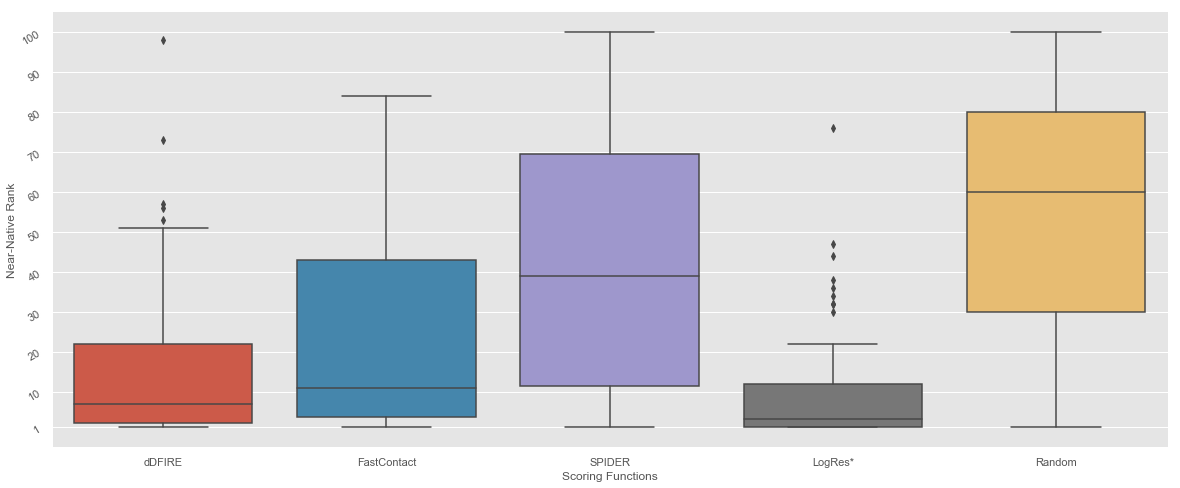

In [10]:
hit_stats = mu.get_hit_stats(models)

plt.figure(figsize=(20, 8))
plt.ylabel('Hit Rank')
plt.xlabel('Score Functions')
ticks = list(range(0, 101, 10))
ticks[0] = 1
plt.yticks(ticks, rotation=30)
sns.boxplot(data=pd.melt(hit_stats), x='variable', y='value')
#hit_stats.boxplot()
sns.despine()
plt.xlabel('Scoring Functions')
plt.ylabel('Near-Native Rank')
plt.savefig('images/hitsboxplot')

## Temporal Performance

In [ ]:
# Load and plot the time comparisons
fe_times = pd.read_pickle('data/times/test_extraction_time')
ddfire_times = pd.read_pickle('data/times/ddfire_times')
fastscore_times = pd.read_pickle('data/times/fast_contact_times')
spider_times = pd.read_pickle('data/times/SPIDER_times')

In [ ]:
# prepare the data for plotting
fe_times.index = fe_times.pdb_code
ddfire_times.index = ddfire_times.code
fastscore_times.index = fastscore_times.code
spider_times.index = spider_times.code

temporal_perf = pd.DataFrame()
temporal_perf = pd.DataFrame(index=fe_times.index, columns=['nres'], data=fe_times.nres)
temporal_perf = pd.concat([temporal_perf, ddfire_times[['time']]], axis=1, sort=False)
temporal_perf = pd.concat([temporal_perf, fastscore_times[['time']]], axis=1, sort=False)
temporal_perf = pd.concat([temporal_perf, spider_times[['time']]], axis=1, sort=False)
temporal_perf = pd.concat([temporal_perf, fe_times[['time']]], axis=1, sort=False)
temporal_perf.columns = ['nres', 'dDFIRE', 'FastContact', 'SPIDER', 'Model']

# Drop those for which there were errors
ntemp = temporal_perf.drop(['2a1t', '1is7', '4fqr', '4gxu', '1w1i', '3l5n'], axis=0)

In [ ]:
gs = gridspec.GridSpec(1, 5, wspace=0.3)
ntemp['LogRes*'] = ntemp['Model']
plt.figure(figsize=(20, 6))
plt.suptitle('Time Requirements in Seconds')
plt.subplot(gs[:,:3])
sns.lineplot(x=ntemp['nres'], y=ntemp['dDFIRE'])
sns.lineplot(x=ntemp['nres'], y=ntemp['FastContact'])
sns.lineplot(x=ntemp['nres'], y=ntemp['SPIDER'])
sns.lineplot(x=ntemp['nres'], y=ntemp['LogRes*'])
plt.ylabel('Time in Seconds per 100 decoys (Log Scale)')
plt.legend(['dDFIRE', 'FastContact', 'SPIDER', 'LogRes*'], loc='upper left')
plt.yscale('log')
plt.xlabel('Number of Residues')

plt.subplot(gs[:,3:])
tt = ntemp.drop(['nres', 'Model'],axis=1).melt()
sns.boxplot(y=tt['value'], x=tt['variable'])
plt.xlabel('Scoring Function')
plt.ylabel('')
plt.yscale('log')

plt.savefig('images/temporal_performance', dpi=300)